<a href="https://colab.research.google.com/github/luisdiaz1997/BioinformaticsExamples/blob/master/BIOE300_HM1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [267]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson

In [268]:
#genes on, genes off, mrna
update = np.array([
                   [-1, 1, 0], #gene goes from on to off
                   [1, -1, 0], #gene goes from off to on
                   [0, 0, 1], #mrna produced
                   [0, 0, -1] #mrna degraded
])

In [269]:
def gillispie(a_reactions: np.ndarray, prng):
  #time for reaction
  a_total = np.sum(a_reactions)
  if a_total == 0:
    return 0, 0
  
  r1 = prng.rand()
  t = (1/(a_total)) * np.log(1/r1) 


  #get index of random reaction
  r2 = prng.rand()
  target = a_total * r2
  q = 0
  sum_as = 0

  for i, reaction in enumerate(a_reactions):
    sum_as += reaction
    if sum_as > target:
      q = i
      break

  return t, q

In [270]:
def start_simulation(rates: np.ndarray, seed=12, steps = 1000):

  prng = np.random.RandomState(seed)
  X = np.zeros((steps+1, 3))
  tt = np.zeros(steps+1)
  X[0] = np.array([0, 1, 0])

  for step in range(steps):
    a = np.zeros(4)
    a[0] = rates[0]*X[step, 0] #dna on to off
    a[1] = rates[1]*X[step, 1] #dna off to on
    a[2] = rates[2]*X[step, 0] #rna produced
    a[3] = rates[3]*X[step, 2] #rna degraded

    t, q = gillispie(a, prng)
    if t==0:
      print('simulation ends at step:', step)
      break
    tt[step+1] = tt[step] + t
    X[step+1] = X[step] + update[q]

  return tt[:step+1], X[: step+1]



In [271]:
def plot(tt, X):
  plt.figure(figsize=(15, 3))
  plt.subplot(2,1,1)
  plt.plot(tt, X[:, 0], drawstyle='steps-post')
  plt.gca().set_xticks([])
  plt.ylabel('genes on')
  plt.ylim([-0.1, 1.1])

  plt.subplot(2,1,2)
  plt.plot(tt, X[:, 2])
  plt.ylabel('Number of RNAs')
  plt.xlabel('time seconds')
  

##Question 1a

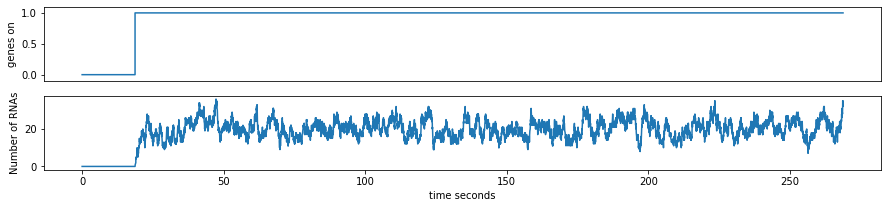

In [272]:
rates1 = np.array([0, 0.1, 20, 1])
tt, X = start_simulation(rates1, steps=10000)
plot(tt, X)

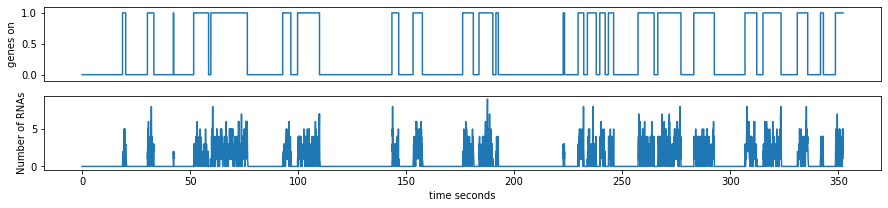

In [273]:
rates2 = np.array([0.2, 0.1, 20, 10])
tt, X = start_simulation(rates2, steps=5000)
plot(tt, X)

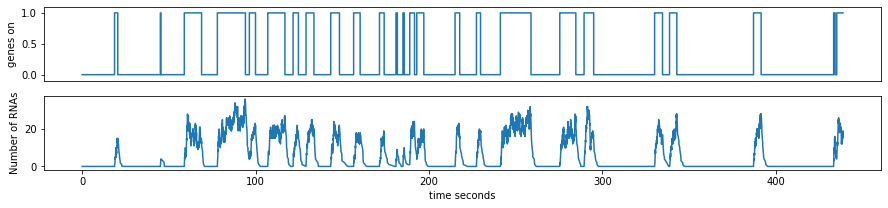

In [274]:
rates3 = np.array([0.2, 0.1, 20, 1])
tt, X = start_simulation(rates3, steps=5000)
plot(tt, X)

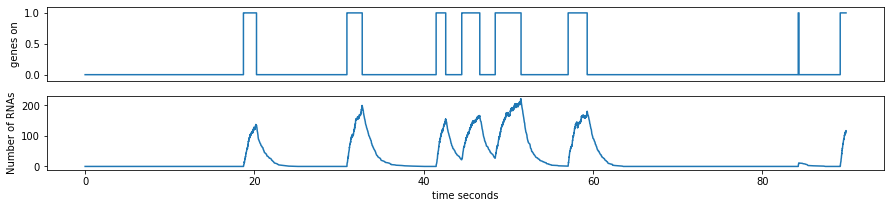

In [275]:
rates4 = np.array([0.2, 0.1, 200, 1])
tt, X = start_simulation(rates4, steps=5000)
plot(tt, X)

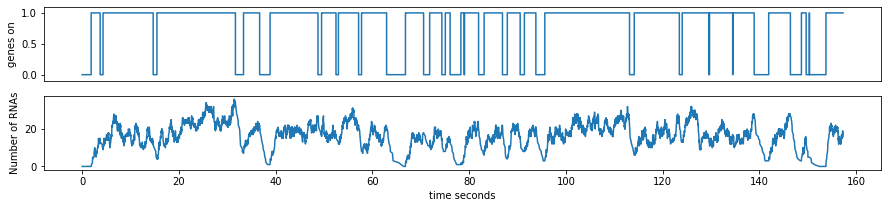

In [276]:
rates5 = np.array([0.2, 1, 20, 1])
tt, X = start_simulation(rates5, steps=5000)
plot(tt, X)

### The mRNA counts are very correlated with DNA on. 

## question 1b

In [277]:
steady_state = lambda rates: 1+(rates[1]/(rates[0]+rates[1]))*(rates[2]/rates[3])

In [278]:
p = np.arange(0 ,10)
np.insert(p, 0, 20)

array([20,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9])

In [279]:
def get_p(rates, n_vector):
  n_vector = n_vector[1:]
  const1 = rates[1]/(rates[0]+ rates[1])
  const2 =  rates[0]/(rates[0]+ rates[1])
  const3 = rates[2]/rates[3]
  p = const1*poisson.pmf(n_vector, const3)
  p = np.insert(p, 0, (const1*np.exp(-const3)) + const2)
  return p

In [280]:
def build_kde(tt, signal):
  max_signal = int(np.max(signal))
  tt_diff = np.diff(tt)
  p = np.zeros(max_signal+1)
  for i, element in enumerate(signal[:-1]):
    p[int(element)] += tt_diff[i]
  p /= p.sum()
  return p

In [285]:
def plot_histogram(rates, seed=10, steps=10000):
  tt, X = start_simulation(rates, seed=seed, steps=steps)
  p_data = build_kde(tt, X[:, 2])
  x = np.arange(0, len(p_data))
  p = get_p(rates, x)
  plt.bar(x, p_data)
  plt.plot(x, p, color='black')
  plt.xlabel('mRNA counts')
  plt.ylabel('probability')

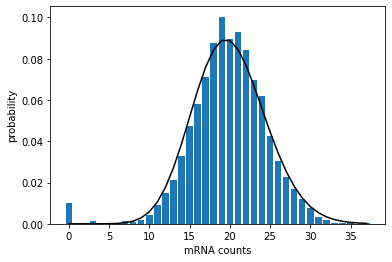

In [286]:
plot_histogram(rates1)

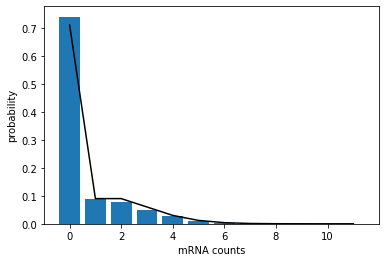

In [245]:
plot_histogram(rates2)

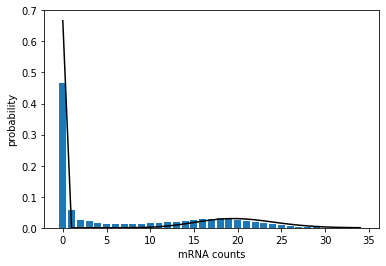

In [246]:
plot_histogram(rates3)

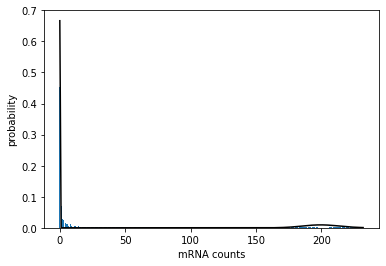

In [247]:
plot_histogram(rates4)

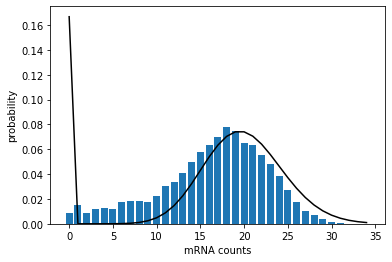

In [248]:
plot_histogram(rates5)

### The distributions from the simulations match the P(n) curves well for most cases, except on the 5th case, were it the curve matches but not the spike at zero.

## Question 1c

In [249]:
def multiscales(rates, scales, xlim):

  plt.figure(figsize=(17, 3))
  for i, scale in enumerate(scales):
    curr_rates = rates.copy()
    curr_rates[0] *= scale
    curr_rates[1] *= scale
    plt.subplot(1, len(scales), i+1)
    plot_histogram(curr_rates)
    if i>0:
      plt.ylabel('')
    plt.ylim([0, 1])
    plt.xlim(xlim)
    plt.title(str(scale)+r'$\alpha$')

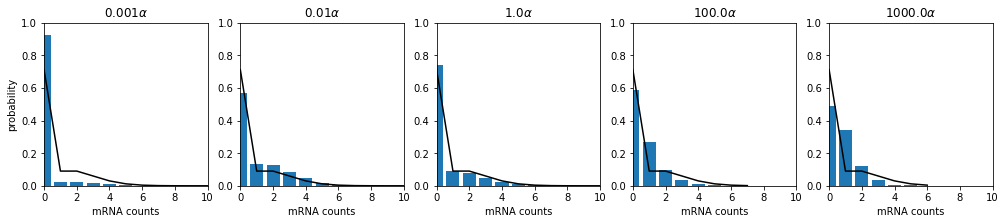

In [250]:
multiscales(rates2, scales= [1e-3, 1e-2, 1e-0, 1e2, 1e3], xlim = [0, 10])

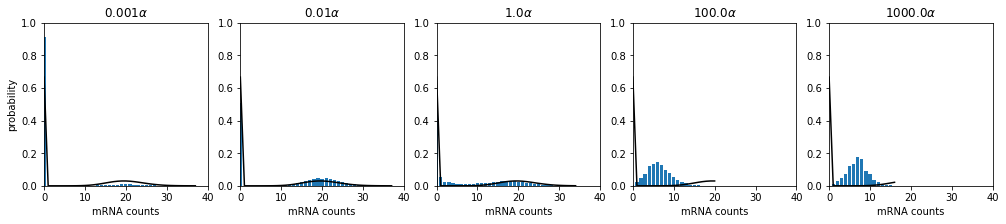

In [251]:
multiscales(rates3, scales= [1e-3, 1e-2, 1e-0, 1e2, 1e3], xlim = [0, 40])

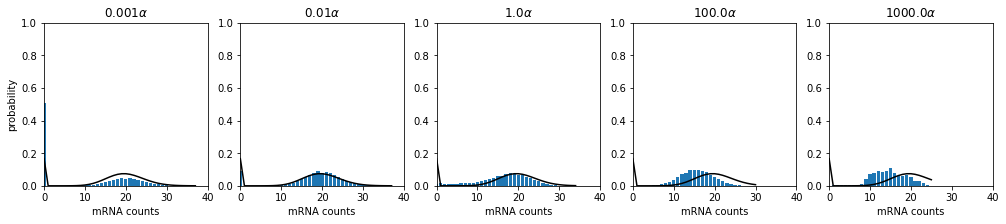

In [252]:
multiscales(rates5, scales= [1e-3, 1e-2, 1e-0, 1e2, 1e3], xlim = [0, 40])

### While keeping $\frac{\alpha}{\beta}$ constant, smaller values of $\alpha$ move the distribution to the left, while bigger values of $\alpha$ move the distribution to the right.

### The P(n) distribution fails when $\alpha$ is large in most cases

# Question 1d

<img src='https://i.imgur.com/pJ0JLNV.png' width="400" height="300">

#### The figure from the paper looks like the second plot from 1a, with $\alpha=0.2$, $\beta=0.1$, $K_{1}$=20 and $\gamma=10$ which is the following:

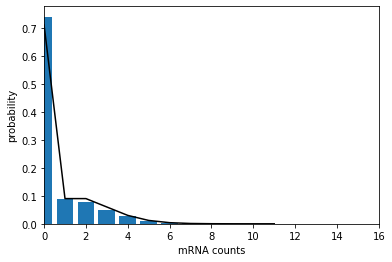

In [260]:
plot_histogram(rates2)
plt.xlim([0, 16]);

#Question 1e

#### According to https://bionumbers.hms.harvard.edu/bionumber.aspx?id=111919&ver=3&trm=mRNA+numbers+per+gene+per+cell+for+mammalian+cells&org=

There is about 0.02-3 mRNAs per gene in Ecoli

#### And according to https://bionumbers.hms.harvard.edu/bionumber.aspx?id=106376&ver=7&trm=mRNA+numbers+per+gene+per+cell+for+mammalian+cells&org=

There is a median of 15 mRNAs per gene in mammalians

It might be true that girase influences transcription in E.Coli but this might not be the case in mammalian cells since it has a higher amount of mRNAs produced, and might be due to other transcription factors or SMC (structural maintenance of chromosomes) factors.



#Question 2a


### The probability of a cell having all N mutations is $P(A) = P(A_{1}=S)P(A_{2}=S)...P(A_{N}=S)$ where S is success. And if $P(A_{i})=E$

So for a vector of mutations $A=A_{1}A_{2}...A_{n}$ the probability of all of them being succesful $P(A) = E^N$ 

In [266]:
E = 0.55
N = 10
print('Probability is:', E**N)

Probability is: 0.0025329516211914085


#Question 2b

If you want to achieve 95% success in 5 mutations.
Then $E^5 = 0.95$

then $5log(E) = log(0.95)$

Finally $E = 0.95^{\frac{1}{5}}$

In [284]:
E = 0.95**(1/5)
print('E =', E)

E = 0.9897937816869885
